In [1]:
from __future__ import annotations
import os
import random
import time

from pathlib import Path
from glob import glob
from PIL import Image
from typing import Tuple, Dict, List
from timeit import default_timer as timer
from tqdm import tqdm

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
import torch.nn as nn
import torchvision
# import torchinfo

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
# from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import RandAugment
from torch.autograd.grad_mode import inference_mode

### DataSet

In [8]:
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()   # verify the contents of a file. If the file is broken
        return True
    except (IOError, SyntaxError, Image.UnidentifiedImageError):
        print(f"Skipping corrupted file: {path}")
        return False

In [10]:
train_path = Path("./data/data/train")
test_path = Path("./data/data/test")

def get_data(train_path, test_path):

  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]

  train_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
  ])
  train_transform.transforms.insert(0, RandAugment(num_ops=2, magnitude=9))

  test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.Normalize(mean=mean, std=std)
  ])

  train_data = ImageFolder(root=train_path,
                         transform=train_transform,
                         target_transform=None,
                        is_valid_file = is_valid_image)

  test_data = ImageFolder(root=test_path,
                         transform=train_transform,
                        is_valid_file = is_valid_image
                        )

  return train_data, test_data

In [11]:
train_data, test_data = get_data(train_path, test_path)

Skipping corrupted file: data/data/train/Cat/666.jpg
Skipping corrupted file: data/data/train/Dog/11702.jpg


In [12]:
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [13]:
class_index = train_data.class_to_idx
class_index

{'Cat': 0, 'Dog': 1}

In [14]:
len(train_data), len(test_data)

(24958, 34)

In [17]:
def random_image():
    img_path = Path(train_path)
    img_list = list(Path(train_path).glob("*/*.jpg"))
    random_img = random.choice(img_list)
    img_class = random_img.parent.stem
    print("Image Path: {}".format(random_img))
    print("image Class: {}".format(img_class))
    img = Image.open(random_img)
    return img

Image Path: data/data/train/Dog/4990.jpg
image Class: Dog


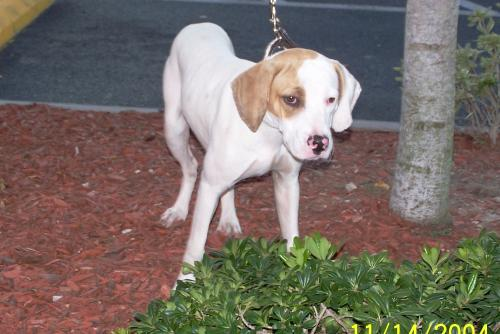

In [18]:
random_image()

### Loaders

In [19]:
def loaders(train_data, test_data):
  train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

  return train_loader, test_loader

In [20]:
train_loader, test_loader = loaders(train_data, test_data)

In [21]:
len(train_loader) , len(test_loader)

(780, 2)

In [22]:
image, label = next(iter(train_loader))
image.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#### Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [5]:
# weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
# model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

In [25]:
torchinfo.summary(model=model,
                  input_size=[32, 3, 384, 384],
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 384, 384]    [32, 1000]           --                   True
├─Sequential: 1-1                                       [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 384, 384]    [32, 24, 192, 192]   --                   True
│    │    └─Conv2d: 3-1                                 [32, 3, 384, 384]    [32, 24, 192, 192]   648                  True
│    │    └─BatchNorm2d: 3-2                            [32, 24, 192, 192]   [32, 24, 192, 192]   48                   True
│    │    └─SiLU: 3-3                                   [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential: 2-2                                  [32, 24, 192, 192]   [32, 24, 192, 192]   --                   True
│    

#### Freeze Layers

In [26]:
for param in model.features.parameters():
    param.requires_grad = False

for param in model.features[-3:].parameters():
    param.requires_grad = True

In [27]:
data_classes = train_data.classes
data_classes

['Cat', 'Dog']

In [28]:
# num_classes = len(data_classes)
model.classifier = nn.Sequential(
                        nn.Dropout(p=0.3, inplace=True),
                        nn.Linear(1280, 512),
                        nn.BatchNorm1d(512),
                        nn.SiLU(inplace=True),
                        nn.Dropout(p=0.2),
                        nn.Linear(in_features=512,
                                  out_features=2,
                                  bias=True)
                        ).to(device)

In [29]:
torchinfo.summary(model=model,
                  input_size=[32, 3, 384, 384],
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 384, 384]    [32, 2]              --                   Partial
├─Sequential: 1-1                                       [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   Partial
│    └─Conv2dNormActivation: 2-1                        [32, 3, 384, 384]    [32, 24, 192, 192]   --                   False
│    │    └─Conv2d: 3-1                                 [32, 3, 384, 384]    [32, 24, 192, 192]   (648)                False
│    │    └─BatchNorm2d: 3-2                            [32, 24, 192, 192]   [32, 24, 192, 192]   (48)                 False
│    │    └─SiLU: 3-3                                   [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential: 2-2                                  [32, 24, 192, 192]   [32, 24, 192, 192]   --                   F

### Train Model

In [30]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [38]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_accuracy = 0.0, 0.0
    scaler = torch.cuda.amp.GradScaler()  # Initialize scaler

    for batch, (img, label) in enumerate(dataloader):
        img, label = img.to(device), label.to(device)

        with torch.cuda.amp.autocast():  # Mixed precision forward
          prediction = model(img)
          loss = loss_fn(prediction, label)

        scaler.scale(loss).backward() # Scale gradients
        scaler.step(optimizer)    # Update weights
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()

        pred_class = prediction.argmax(dim=1)
        train_accuracy += accuracy_fn(y_true = label, y_pred = pred_class)

    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)

    return train_loss, train_accuracy

In [32]:
def test_step( model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss, test_accuracy = 0.0, 0.0
    for batch, (img, label) in enumerate(dataloader):
        img, label = img.to(device), label.to(device)

        prediction = model(img)
        loss = loss_fn(prediction, label)
        test_loss += loss.item()

        pred_class = prediction.argmax(dim=1)
        test_accuracy += accuracy_fn(y_true = label, y_pred = pred_class)

    test_loss = test_loss / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)

    return test_loss, test_accuracy

In [41]:
def train_model(model:torch.nn.Module,
                train_loader: torch.utils.data.DataLoader,
                test_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                num_epochs: int,
                device: torch.device,
                save_step: int = 5,
                first_epoch: int = 0,
                model_name: str= "EfficientNet_V2"
               ) -> Dict[str, List]:
    # results = {
    #     "train_loss":[],
    #     "train_accuracy":[],
    #     "test_loss":[],
    #     "test_accuracy":[]
    # }

    writer = SummaryWriter("tb_loggers")
    model = model

    root_path = f"saved_models/{model_name}"
    os.makedirs(root_path, exist_ok = True)

    #load model
    if first_epoch >= 1:
        checkpoint_path = os.path.join(root_path, f"model_{model_name}_{first_epoch}.pth")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        best_accuracy = checkpoint.get("best_accuracy", 0.0)
        print(f"Resuming Training from epoch {first_epoch}, best accuracy so far: {best_accuracy:.4f}")

    best_accuracy = 0.0
    # start to train
    for epoch in tqdm(range(first_epoch+1, num_epochs+1), total=num_epochs, initial=first_epoch):
        path_to_save = os.path.join(root_path, f"model_{model_name}_{epoch}.pth")
        path_to_save_best_model = os.path.join(root_path, "best_model.pth")

        start_train = time.time()
        train_loss, train_accuracy = train_step(model = model,
                                               dataloader = train_loader,
                                               loss_fn = loss_fn,
                                               optimizer = optimizer,
                                               device = device)
        end_train = time.time()

        start_test = time.time()
        test_loss, test_accuracy = test_step(  model = model,
                                               dataloader = test_loader,
                                               loss_fn = loss_fn,
                                               device = device)
        end_test = time.time()
        scheduler.step(test_accuracy)

        print(
            f"Epoch: {epoch} | "
            f"Training Loss: {train_loss:.4f} | "
            f"Training Accuracy: {train_accuracy:.4f} | "
            f"Training Time: {end_train - start_train:.3f} ||"
            f"Test Loss: {test_loss:.4f} | "
            f"Test Accuracy: {test_accuracy:.4f} | "
            f"Testing Time: {end_test - start_test:.3f}"
        )

        # save loss and accuracy
        # results["train_loss"].append(train_loss)
        # results["train_accuracy"].append(train_accuracy)
        # results["test_loss"].append(test_loss)
        # results["test_accuracy"].append(test_accuracy)

        # save model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(
                {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_accuracy": best_accuracy,
                },
                path_to_save_best_model)

            print("Model saved at {}".format(path_to_save))
            print("="*100)

        if epoch % save_step == 0:
            torch.save(
                {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_accuracy": best_accuracy,
                }, path_to_save)

          # log to tensorboard
            writer.add_scalar("Loss/train", train_loss, epoch, walltime=True)
            writer.add_scalar("Accuracy/train", train_accuracy, epoch, walltime=True)
            writer.add_scalar("Loss/test", test_loss, epoch, walltime=True)
            writer.add_scalar("Accuracy/test", test_accuracy, epoch, walltime=True)
    writer.close()
    return #results


In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [35]:
num_epochs = 10

In [ ]:
results = train_model(model = model,
                    train_loader = train_loader ,
                    test_loader = test_loader,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    num_epochs = num_epochs,
                    first_epoch = 0,
                    save_step = 5,
                    device = device)

### Inference

In [10]:
class_names = ["cat", "dog"]

In [22]:
def get_model():
  weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
  model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

  for param in model.features.parameters():
    param.requires_grad = False

  for param in model.features[-3:].parameters():
    param.requires_grad = True

  model.classifier = nn.Sequential(
                        nn.Dropout(p=0.3, inplace=True),
                        nn.Linear(1280, 512),
                        nn.BatchNorm1d(512),
                        nn.SiLU(inplace=True),
                        nn.Dropout(p=0.2),
                        nn.Linear(in_features=512,
                                  out_features=2,
                                  bias=True)
                        ).to(device)
  return model


In [12]:
def image_to_inference(image_path):
  image = Image.open(image_path)

  transform = transforms.Compose([
  transforms.Resize((384, 384)),
  transforms.ToTensor()
])

  transformed_image = transform(image)
  transformed_image = transformed_image.unsqueeze(0)

  return transformed_image

In [26]:
def inference(model, model_checkpoint, image_path):
  checkpoint = torch.load(model_checkpoint, map_location="cpu")
  model.load_state_dict(checkpoint["model_state_dict"])

  image = image_to_inference(image_path)

  with inference_mode():
    model.eval()
    prediction = model(image)
    prediction = prediction.argmax(dim=1)

    class_name = class_names[prediction]
    print(f"Prediction: {class_name}")



In [27]:
model_checkpoint="./saved_models/EfficientNet_V2/best_model.pth"
# image_path="./data/data/test/Cat/001.jpg"
image_path="./data/data/test/Dog/001.jpg"
inference(model=get_model(), model_checkpoint=model_checkpoint, image_path=image_path)

Prediction: dog
